In [3]:
%matplotlib inline
import yfinance as yf
import pandas as pd
import numpy as np
from __future__ import division
from numpy.linalg import inv,pinv
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as lns
from IPython.display import display, HTML
from scipy.optimize import minimize

In [21]:
tickers = ['FIGRX', 'FSCOX', 'FEDDX', 'FTEMX', 'FSPSX', 'FSGGX', 'FPADX', 'FIVFX', 'FIREX', 'FISMX']
date_interval = '1mo'

# YYYY-MM-DD
start_date = '2019-05-01'
end_date = '2024-06-01'

In [ ]:
returns = []
for ticker in tickers:
    download_df = yf.download(ticker, start=start_date, end=end_date, interval=date_interval)
    download_df = download_df[['Adj Close']]
    # download_df[f'{ticker}'] = np.log(download_df['Adj Close'].div(download_df['Adj Close'].shift(1))) # Log returns
    download_df[f'{ticker}'] = download_df['Adj Close'].div(download_df['Adj Close'].shift(1)) - 1 # Arithmetic returns
    returns.append(download_df[f'{ticker}'])

In [23]:
df = pd.DataFrame(returns).T
df.dropna(inplace=True)
# df.to_excel('data/returns.xlsx')

In [25]:
covariance_matrix = df.cov()*12   # Annualized
covariance_matrix

,FIGRX,FSCOX,FEDDX,FTEMX,FSPSX,FSGGX,FPADX,FIVFX,FIREX,FISMX
FIGRX,0.033098,0.033245,0.031530,0.027646,0.030986,0.030121,0.028115,0.032155,0.027305,0.031301
FSCOX,0.033245,0.040282,0.030725,0.028400,0.033334,0.031902,0.028650,0.035323,0.030757,0.032495
FEDDX,0.031530,0.030725,0.040247,0.031907,0.029476,0.030729,0.033402,0.029402,0.025859,0.033157
FTEMX,0.027646,0.028400,0.031907,0.030944,0.027753,0.029037,0.032276,0.027171,0.024099,0.028345
FSPSX,0.030986,0.033334,0.029476,0.027753,0.033347,0.031846,0.028341,0.030959,0.028985,0.031649
FSGGX,0.030121,0.031902,0.030729,0.029037,0.031846,0.031386,0.030299,0.029853,0.027658,0.030898
FPADX,0.028115,0.028650,0.033402,0.032276,0.028341,0.030299,0.035306,0.027220,0.024373,0.029042
FIVFX,0.032155,0.035323,0.029402,0.027171,0.030959,0.029853,0.027220,0.035704,0.029205,0.029635
FIREX,0.027305,0.030757,0.025859,0.024099,0.028985,0.027658,0.024373,0.029205,0.034981,0.028824
FISMX,0.031301,0.032495,0.033157,0.028345,0.031649,0.030898,0.029042,0.029635,0.028824,0.034004


In [26]:
def portfolio_std_dev(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, returns):
    return np.sum(returns.mean() * weights) * 12  # Annualized return

In [27]:
def optimize_portfolio(target_return, returns, cov_matrix):
    """
    Optimize a portfolio to achieve a specified target return while minimizing risk.

    This function uses the Sequential Least Squares Programming (SLSQP) method to 
    find the optimal asset weights that minimize portfolio standard deviation 
    while ensuring that the sum of weights equals one and that the expected portfolio 
    return matches the specified target return.

    Parameters:
    -----------
    target_return : float
        The desired expected return of the portfolio.

    returns : pandas.DataFrame
        A DataFrame containing historical returns of the assets. Each column represents 
        an asset, and each row represents the MONTHLY returns.

    cov_matrix : numpy.ndarray
        The covariance matrix of asset returns, which quantifies how asset MONTHLY 
        returns move together.

    Returns:
    --------
    tuple
        A tuple containing:
            - numpy.ndarray: The optimized weights for each asset in the portfolio.
            - float: The minimized portfolio standard deviation corresponding to 
                      the optimized weights.

    Raises:
    -------
    ValueError: If target_return is not achievable with the given returns.
    
    Examples:
    ---------
    >>> optimized_weights, min_std_dev = optimize_portfolio(0.05, returns_df, cov_matrix)
    """
    
    num_assets = len(returns.columns)
    args = (cov_matrix,)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: portfolio_return(x, returns) - target_return}
    )
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(portfolio_std_dev, num_assets*[1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x, result.fun

def optimize_portfolio_no_target(returns, cov_matrix):
    """
    Optimize a minimum standard deviation (risk) portfolio.

    This function uses the Sequential Least Squares Programming (SLSQP) method to 
    find the optimal asset weights that minimize portfolio standard deviation 
    while ensuring that the sum of weights equals on.

    Parameters:
    -----------
    returns : pandas.DataFrame
        A DataFrame containing historical returns of the assets. Each column represents 
        an asset, and each row represents the MONTHLY returns.

    cov_matrix : numpy.ndarray
        The covariance matrix of asset returns, which quantifies how asset MONTHLY 
        returns move together.

    Returns:
    --------
    tuple
        A tuple containing:
            - numpy.ndarray: The optimized weights for each asset in the portfolio.
            - float: The minimized portfolio standard deviation corresponding to 
                      the optimized weights.

    Raises:
    -------
    ValueError: If target_return is not achievable with the given returns.
    
    Examples:
    ---------
    >>> optimized_weights, min_std_dev = optimize_portfolio_no_target(returns_df, cov_matrix)
    """
    num_assets = len(returns.columns)
    args = (cov_matrix,)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    )
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(portfolio_std_dev, num_assets*[1./num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x, result.fun

In [28]:
optimize_portfolio_no_target(df, covariance_matrix)

(array([1.31656000e-01, 0.00000000e+00, 0.00000000e+00, 5.29714993e-01,
        0.00000000e+00, 1.13841228e-17, 2.87313576e-17, 1.58293517e-17,
        3.38629006e-01, 1.66967135e-17]),
 0.16794081057774485)

In [39]:
results = []
test_values = [i for i in np.arange(0.015, 0.085, 0.005)]
for exp_returns in test_values:
    pf_weights, std = optimize_portfolio(exp_returns, df, covariance_matrix)
    results.append((exp_returns, std))

In [40]:
results_df = pd.DataFrame(results, columns=["Exp Returns", "Std"])
results_df

,Exp Returns,Std
0,0.015,0.186044
1,0.020,0.178188
2,0.025,0.172473
3,0.030,0.169118
4,0.035,0.168152
5,0.040,0.167957
6,0.045,0.167980
7,0.050,0.168224
8,0.055,0.168637
9,0.060,0.169180


Text(0, 0.5, 'Expected Returns')

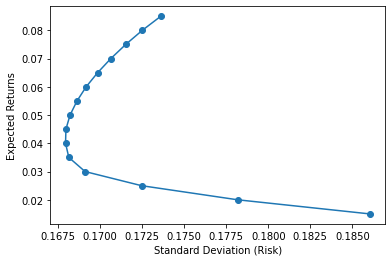

In [41]:
plt.plot(results_df["Std"], results_df['Exp Returns'],marker='o')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Returns')